# Airbnb: Boston and Seattle

This is my first (last?) blog post. This is actually an assignement for the second term of Udacity's Data Scientist nanodegree.

In this post I will explore a dataset, kindly provided to us by Airbnb through Kaggle, which covers all activity for one year in Boston and Seattle. The files consist of:

- property listings
- a calendar for each property
- guest reviews

Property listings has quite many features and it is by far the most important data resource. It contains all the information you need to know about the property with details about ratings and some bookkeeping information. Calendar shows day by day if each property was occupied or not. It also shows the price when the property was vacant. Most of my analysis is based on combining information from listings and calendar.

The last file of the dataset has the reviews. This basically contains the text of the review and the who made it and when. I am actually not using this file. Reviews are hard to parse because of the very coloquial writing. Moreover, a sizable number of them are written in languages other than English. However, the most important reason I am not using it is that, by far, most of the reviews are good. That's at least what I found out after doing some prospective tests. It seems that most of the people only write reviews when they like the place.

So let's start our analysis. We must load the libraries and the files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re as re

%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.feature_extraction import text 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 4000)
pd.options.display.max_colwidth = 500

In [4]:
#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

Each city has three datasets: calendar, listings and reviews. Let's load all of them.

In [5]:
cities = ['boston', 'seattle']

In [6]:
boston_calendar = pd.read_csv('data/boston/calendar.csv')
boston_listings = pd.read_csv('data/boston/listings.csv')
boston_reviews = pd.read_csv('data/boston/reviews.csv')

seattle_calendar = pd.read_csv('data/seattle/calendar.csv')
seattle_listings = pd.read_csv('data/seattle/listings.csv')
seattle_reviews = pd.read_csv('data/seattle/reviews.csv')

Let's take a look at how Calendar and Listings look like.

The Calendar dataframe looks very ordinary. It tells us the id of the property and if it is available or not on a certain day. It also contains the rent price.

In [7]:
boston_calendar.shape

(1308890, 4)

In [8]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


Now let's take a look at the reviews.

In [9]:
boston_reviews.shape

(68275, 6)

In [10]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival. The airport T Station is only a 5-10 min walk away. The only little issue was that all the people in the house had to share one bathroom. But it was not really a problem and it worked out fine. We would recommend Islams place for a stay in Boston.
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the commodities. Very close to the airport metro station and located in quite safe area. Islam responds very quickly and is very helpful. I would recommend it.
4,1178162,5171140,2013-06-16,6848427,Andrew,"Great location. Just 5 mins walk from the Airport Station. Good food nearby.\r\nRoom was simple, clean, just what I was after."


The listings dataframe is completely different. Although shorter in length, it contains many more columns with a wide variety of details about each property. Let's take a look at one of the entries.

In [11]:
boston_listings.shape

(3585, 95)

As we can see, many of the columns are not really useful. This is actually the tricky part of this analysis. How do you know if some piece information will be relevant to predict the price or occupation? I will later choose the ones I consider the most important and try to squeeze some predictions out of it.

Another important thing about listings is that it has a lot of null entries.

In [13]:
boston_listings.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              143
space                               1057
description                            0
experiences_offered                    0
neighborhood_overview               1415
notes                               1975
transit                             1290
access                              1489
interaction                         1554
house_rules                         1192
thumbnail_url                        599
medium_url                           599
picture_url                            0
xl_picture_url                       599
host_id                                0
host_url                               0
host_name                              0
host_since                             0
host_location                         11
host_about      

The post must follow the so-called CRISP-DM process. I actually wasn't really sure if this was really a thing but it looks like it has been around for some time as we can see [here](https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining)

The CRISP-DM process consists of the following steps:

1. Business understanding
2. Data understanding
3. Prepare data
4. Data Modelling
5. Evaluate results
6. Deploy

We will not deploy our solution but we still need to take care of all the previous steps. Let's start with the Business questions and develop data understanding as we go. The data will also be prepared according to the demands of each question.

## Business Questions

The dataset is quite rich and it was easy to come up with a few interesting business questions. Here are the ones that caught my attention:

1. How is property occupation along the year? (easy one for warming up)
2. For how long a property is occupied and how much owners earn?
2. Can we determine what are the main predictors for property prices?
3. What are the characteristics of the busiest properties?
4. What are the most popular neighbourhoods? Can we understand why they are popular?

That's it. Let's solve these questions.

## 1. How occupation changes with time? 

The first question that came to my mind was to check how occupation and earnings change as a function of time. That's a pretty easy one and it can give us some insight about the dataset. Let's take a look at the calendar. It has dates condensed in a single string. What we need to do is to break them up in separate year, month, and day columns. 

In [15]:
# convert dates to year - month - day
for city in cities:
        calendar = locals()[city+'_calendar'].copy()
        calendar[['year','month','day']] = calendar['date'].str.split(pat='-', expand=True)
        locals()[city+'_calendar'] = calendar.copy()

In [28]:
# define palettes for plots
palette = sns.color_palette("BrBG",9).as_hex()
boston_colors = []
seattle_colors = []
boston_colors.extend([palette[0], palette[1], palette[2]])
seattle_colors.extend([palette[8], palette[7], palette[6]])
print(boston_colors, seattle_colors)

['#8b500a', '#bf812d', '#dec17b'] ['#01655d', '#35978f', '#7fccc0']


### What is the average occupation per month?

According to the calendar, every day an unit is occupied, the price is shown as NaN. So, to measure occupation, we just need to count the number of NaNs per month.

In [134]:
# there is actually one mistake in the Boston dataset. Unit 12898806 has been occupied for more than 365 days.
boston_rent[boston_rent['occupied']>365]

,listing_id,occupied
2727,12898806,570


<Figure size 432x288 with 0 Axes>

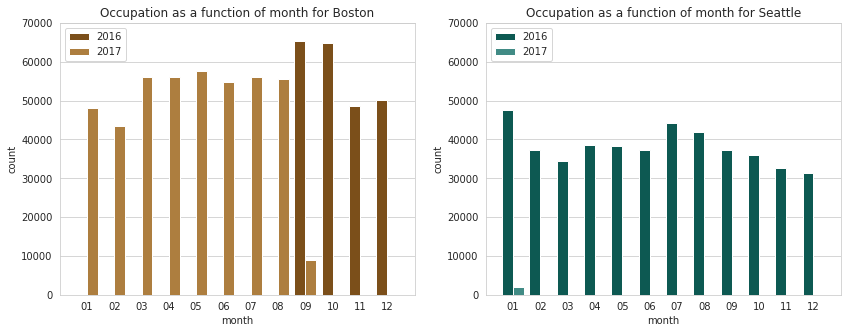

In [140]:
sns.set_style("whitegrid");
sns.despine();
fig, axis = plt.subplots(1, len(cities), figsize=(14,5));

for i, city in enumerate(cities):
    calendar = locals()[city+'_calendar'].copy()
    occup = calendar[calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
    occup.rename(columns={0:'count'}, inplace=True)
    colors = locals()[city+'_colors'][:2]
    sns.barplot(x='month', y='count', hue='year', data=occup, ax=axis[i], palette=colors);
    axis[i].legend(loc='upper left');
    axis[i].set_title('Occupation as a function of month for {}'.format(city.capitalize()));
    axis[i].set_xlim((-1,12));
    axis[i].set_ylim((0,70000));

For Boston, the occupation is quite steady during spring and summer and lower during winter. However, data is limited to one year so we can't be quite sure about this trend. For Seattle, January is popular, probably due to winter birds escaping from the snow. We also see some high demand during the peak of summer. The overall occupation in Boston is higher than in Seattle for all months.

## 2. For how long properties are occupied? 

### By the way, how much owners earn?

Instead of looking at a large scale metric like overall occupation per month, let's check for how long units are occupied. To extract this information from Calendar, we only need to count for how long each unit has not been available.

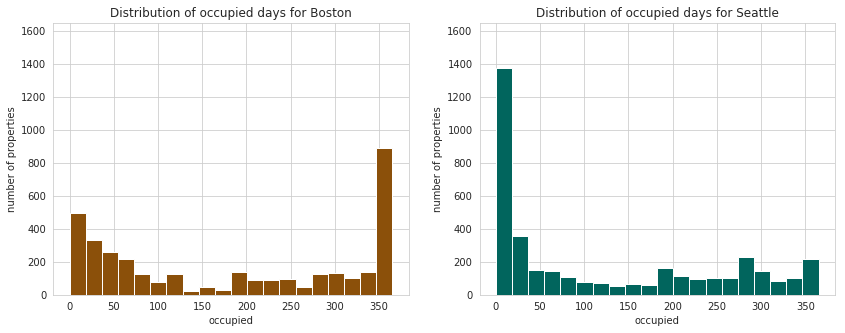

In [148]:
fig, axis = plt.subplots(1, len(cities), figsize=(14,5))

for i, city in enumerate(cities):
    calendar = locals()[city+'_calendar'].copy()
    calendar['occupied'] = calendar['available'].apply(lambda x: 1 if x=='f' else 0)
    rent = calendar.groupby('listing_id').agg({'occupied':'sum'}).reset_index()
    locals()[city+'_rent'] = rent.copy()
    
    if city == 'boston':
        rent.drop([2727],inplace=True)
        rent.reset_index(inplace=True)
        boston_rent.drop([2727], inplace=True)
        boston_rent.reset_index(inplace=True)
    
    color = locals()[city+'_colors'][0]
    sns.distplot(rent['occupied'], 
                 ax=axis[i], 
                 kde=False, 
                 color=color, 
                 bins=20, 
                 hist_kws=dict(alpha=1));
    axis[i].set_title('Distribution of occupied days for {}'.format(city.capitalize()))
    axis[i].set_ylim((0,1650));
    axis[i].set_ylabel('number of properties')

Wow, we found something interesting here. Property occupation in Boston has a peak around 350 days. Are these properties rented out to students? Let's check if this is true.

We can create a dataframe containing just the units that were rented out for more than 350 days and check the preferred neighbourhoods for these long-term renting units. Notice that about 24% of all Boston units fall in this region of long-term renting.

In [142]:
boston_rent[boston_rent['occupied']>350].shape[0] / boston_rent.shape[0]

0.2387726638772664

In [149]:
boston_350 = boston_rent[boston_rent['occupied']>350].copy()

In [150]:
boston_350.shape

(855, 3)

In [151]:
boston_350 = boston_350.merge(boston_listings, how='inner', left_on='listing_id', right_on = 'id')

In [152]:
boston_350.shape

(855, 98)

In [153]:
boston_350.groupby('neighbourhood_cleansed').size().sort_values(ascending=False).reset_index()[:10]

,neighbourhood_cleansed,0
0,Allston,108
1,South End,80
2,Jamaica Plain,79
3,Fenway,69
4,Back Bay,66
5,Brighton,58
6,Beacon Hill,55
7,North End,49
8,Mission Hill,47
9,Downtown,44


That's interesting. Allston is quite close to Harvard and more affordable than Cambridge. South End is close to the Boston University School of Medicine. That's not conclusive, but provides some evidence that these year-round rented units are occupied by students.

On the other hand, property occupation in Seattle is what I would consider as typical: most of the properties were rented for just about a month over an year. Contrasting with Boston, just a few properties were in high demand throughout the year.

Are these long-term rents a good measure of success? Of course the unit is occupied and making money, but that might be by just one tenant for the whole year. It would be interesting to measure how many times the listing was rented to a new tenant. 

Let's create a new column containing the average number of times the unit was rented out. To calculate it we just divide the days the unit was occupied by the average time it was available, which is (maximum_nights + minimum_nights) / 2.

In [154]:
def n_rents(df_rent, df_listings):
    '''
    Calculate the average number of times a unit was rented out
    
    INPUT: df_rent - dataframe with number of occupied days per unit
           df_listings - listings dataframe
           
    OUTPUT: df_rent - input dataframe merged with listings and
            with avg_nights and n_rent columns added
    '''
    df_rent = df_rent.merge(df_listings, 
                            how='inner', 
                            left_on='listing_id', 
                            right_on='id', 
                            suffixes=(False,False))
    df_rent['avg_nights'] = (df_listings['maximum_nights'] +\
                             df_listings['minimum_nights']) / 2.0
    df_rent['n_rent'] = df_rent['occupied'] / df_rent['avg_nights']
    
    return df_rent

In [155]:
for i, city in enumerate(cities):
    
    df_rent = locals()[city+'_rent']
    df_listings = locals()[city+'_listings']
    df_merge = n_rents(df_rent, df_listings)
    locals()[city+'_merge'] = df_merge

In [156]:
(boston_merge.n_rent>300).sum()

7

In [157]:
boston_merge.price.head()

0     $40.00
1    $145.00
2    $195.00
3     $65.00
4    $154.00
Name: price, dtype: object

To finalize, using the merged dataframe, we can calculate earnings by just multiplying occupation by price.

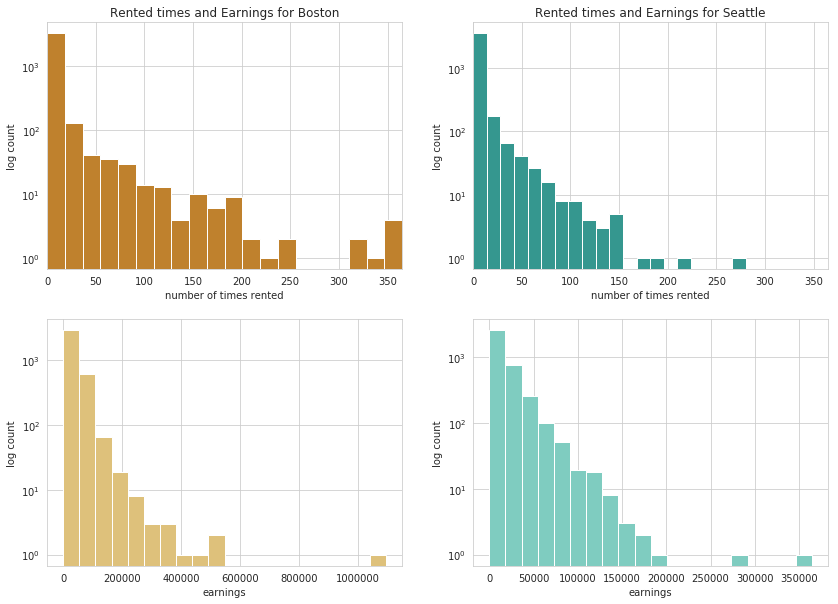

In [162]:
fig, axes = plt.subplots(2,2, figsize=(14,10))

for i, city in enumerate(cities):
    df_merge = locals()[city+'_merge'].copy()
    df_merge['price'] = df_merge['price'].replace('[\$,]', '', regex=True).astype(float)
    df_merge['earnings'] = df_merge['occupied'] * df_merge['price']    

    locals()[city+'_merge'] = df_merge.copy()
    
    colors = locals()[city+'_colors']
    
    sns.distplot(df_merge['n_rent'], ax=axes[0][i], 
                 kde=False, color=colors[1], 
                 bins=20, hist_kws=dict(alpha=1))
    sns.distplot(df_merge['earnings'], ax=axes[1][i], 
                 kde=False, color=colors[2], 
                 bins=20, hist_kws=dict(alpha=1))
    axes[0][i].set_title('Rented times and Earnings for {}'.format(city.capitalize()))
    #tick_locs = [10, 30, 100, 300, 1000, 3000]
    #axes[0][i].set_xticks(np.arange(0,500,20)) 
    #axes[0][i].set_xlim((0,365));
    #axes[0][i].set_xlabel('number of occupied days')
    #axes[0][i].set_ylabel('count')
    axes[0][i].set_xlim((0,365));
    axes[0][i].set_yscale('log');
    axes[0][i].set_xlabel('number of times rented')
    axes[0][i].set_ylabel('log count')
    axes[1][i].set_yscale('log');
    axes[1][i].set_xlabel('earnings')
    axes[1][i].set_ylabel('log count')
    

That's very good. Measuring with n_rent instead of occupation eliminated most of the long-term renting effect. It gives us a more reliable parameter for how many times a unit catches the attention of a new user. That's important if we want to measure how effective our listing is and how well our property stacks with others in the same category. Here are the conclusions for this question:

1. Units are rented for shorter periods in Seattle than in Boston. In Boston, 24% of the units are rented out for more than 350 days an year. We found some evidence that these units are occupied by students.
2. If we consider the number of times the units are rented, most of them are rented less than 20 times an year for both cities. In Boston 9 units are rented more than 300 times an year.
3. In Boston most of the units make less than 100k an year while in Seattle most of them make less than 50k an year. Maximum earnings in Boston are around 500k and there is an outlier making more than 1 million (that doesn't seem right). In Seattle, maximum earnings are around 175k and two outliers around 300k an year. 

## 3. What are the main predictors for property price?

This one might be a common question for property owners: 

        What are most important property features that I need to take care of if I want to raise the price?

My idea to solve this question is to train a supervised learning method that returns a feature importance list and then take the five first elements. AdaBoost is a good choice for this problem.

Starting with the merged dataframes created above, we can down the columns that I considered (very subjectively) might be the most important for this question. This step required me to do some research and to ponder a bit about which columns were worthy keeping. Here is my list:

In [57]:
# I arbitrarily chose these columns 
list_columns = ['id',
                'host_since',
                'host_response_rate',
                'host_acceptance_rate',
                'host_is_superhost',
                'host_listings_count',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms',
                'bedrooms',
                'beds',
                'bed_type',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights',
                'n_rent',
                'occupied',
                'number_of_reviews',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'instant_bookable',
                'cancellation_policy',
                'require_guest_profile_picture',
                'require_guest_phone_verification' ]

Some of the columns are obvious choices but, for example, 'require_guest_profile_picture' is certainly not a clear one. I chose it because if I am a privacy-oriented guest, I would rather not have my picture available on Airbnb (Maybe not. That's just a guess. Maybe I would not even use Airbnb...).

Let's now define a pipeline to clean and preprocess data before having it crunched by a supervised learning method.

In [59]:
def clean_process_pipeline(df):
    '''
    Pipeline to clean and preprocess dataframe before feeding it into
    Supervised Learning method.
    
    INPUT: df - merged dataframe with listings and calendar
           
    OUTPUT: df2 - processed dataframe 
            df2_neigh - data series with neighbourhoods
            df2_id - data series with ids for each property
    '''
    
    df.dropna(subset=['host_since'], inplace=True)
    df['host_since'] = df['host_since'].str.split(pat='-', expand=True)[0]
    base_year = pd.to_numeric(df['host_since'].unique().min())
    df['host_since'] = df['host_since'].apply(lambda x: pd.to_numeric(x) - base_year)
    
    df['host_response_rate'].fillna('0%', inplace=True)
    df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    df['host_acceptance_rate'].fillna('0%', inplace=True)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    
    df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)    
    df['amenities'] = df['amenities'].str.strip('{,}').str.split(pat=',', expand=True).isnull().sum(axis=1)    
    
    df.dropna(subset=['price'], inplace=True)
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_phone_verification'] = df['require_guest_phone_verification'].apply(lambda x: 0 if x=='f' else 1)

    # imputing missing values
    
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df['bathrooms'] = imp_median.fit_transform(df[['bathrooms']])
    df['bedrooms'] = imp_median.fit_transform(df[['bedrooms']])
    df['beds'] = imp_median.fit_transform(df[['beds']])
    
    imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df['property_type'] = imp_mf.fit_transform(df[['property_type']])
    
    # review columns section
    review_re = re.compile('^review')
    list_review = list(filter(review_re.match, df.columns.values.tolist()))
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[list_review] = imp_mean.fit_transform(df[list_review])
    
    # dummies section
    list_dummies = df.select_dtypes(include='object').columns.values.tolist()
    df_dummies = pd.get_dummies(df[list_dummies], drop_first=True)
    df2_neigh = df['neighbourhood_cleansed']
    df2 = pd.merge(df, df_dummies, left_index=True, right_index=True).drop(list_dummies, axis=1)
    
    # separate id column
    df2_id = df2['id']
    df2.drop('id', axis=1, inplace=True)
    
    # scaler section
    list_scale = df.select_dtypes(include=['float64','int64']).columns.values.tolist()
    list_scale.remove('id')
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    df2[list_scale] = scaler.fit_transform(df2[list_scale])
    
    
    return df2_id, df2_neigh, df2

This pipeline returns two data series: one with just the ids, one with just the neighbourhoods and one dataframe with all selected columns properly cleaned from null values, with categorical variables converted to dummies and with numerical variables scaled. 

In [83]:
for city in cities:
    df_merge = locals()[city+'_merge']
    df_id, df_neigh, df = clean_process_pipeline(df_merge[list_columns].copy())
    display(df.head())
    locals()[city+'_df'] = df
#boston_id, boston_neigh, boston_df = price_pipeline(boston_merge[list_columns].copy())
#seattle_id, seattle_neigh, seattle_df = price_pipeline(seattle_merge[list_columns].copy())

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,0.000,0.9,0.78,0.0,0.008011,0.000000,0.166667,0.2,0.0625,0.666667,0.007519,0.020067,3.640000e-06,0.000564,0.203509,0.084158,0.8750,0.875,0.750,0.875,0.833333,0.875,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0.125,1.0,0.90,0.0,0.009346,0.066667,0.166667,0.2,0.0625,0.766667,0.033835,0.006689,7.290000e-06,0.006769,0.036842,0.089109,0.8875,0.875,1.000,1.000,1.000000,0.875,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,0.125,1.0,0.90,0.0,0.009346,0.200000,0.166667,0.2,0.1250,0.433333,0.046366,0.006689,7.290000e-06,0.004680,0.071930,0.116337,0.9375,0.875,1.000,1.000,1.000000,0.750,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.125,1.0,0.88,1.0,0.001335,0.066667,0.166667,0.2,0.0625,0.433333,0.013784,0.006689,4.400000e-07,0.000224,0.080702,0.101485,0.9750,1.000,0.875,1.000,1.000000,0.875,1.000,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,0.125,1.0,0.93,0.0,0.016021,0.133333,0.166667,0.2,0.0625,0.733333,0.036090,0.096990,3.640000e-06,0.019427,0.205263,0.044554,0.8875,1.000,0.875,1.000,0.833333,1.000,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_cleansed_Sunset Hill,neighbourhood_cleansed_University District,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cleansed_Wedgwood,neighbourhood_cleansed_West Queen Anne,neighbourhood_cleansed_West Woodland,neighbourhood_cleansed_Westlake,neighbourhood_cleansed_Whittier Heights,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_str

The next step is to train a regressor with these dataframes. However, after much work, I could not get any regressor to give me a decent result for the Boston data. 

In [84]:
bdf = boston_df.copy()
target='price'
y = bdf[target]
X = bdf.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_reg = AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=1.0)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

0.0974487838446847

My guess is that the dataset is too sparse, too high-dimensional and with too few instances for any regressor to perform well (it is only one year worthy of data). Moreover, if we inspect pairs of variables using scatter plots, we can see that there is no clear trend in the data.

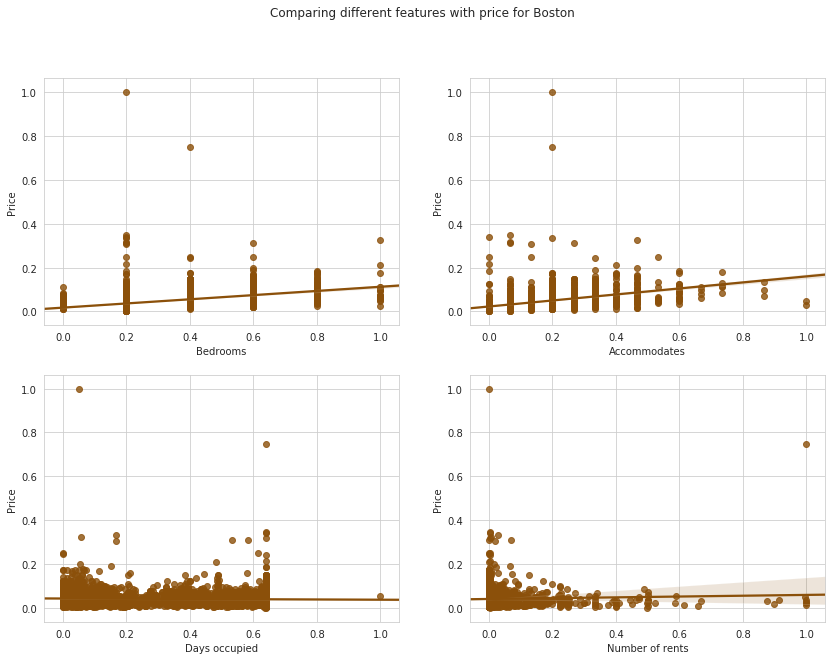

In [85]:
select_df = boston_df[['bedrooms','occupied','accommodates','price','n_rent']].copy()
fig, axes = plt.subplots(2,2, figsize=(14,10))
colors = boston_colors
sns.regplot(x='bedrooms', y='price', data=select_df, ax=axes[0][0], color=colors[0]);
sns.regplot(x='occupied', y='price', data=select_df, ax=axes[1][0], color=colors[0])
sns.regplot(x='accommodates', y='price', data=select_df, ax=axes[0][1], color=colors[0]);
sns.regplot(x='n_rent', y='price', data=select_df, ax=axes[1][1], color=colors[0])
#ax1.legend(loc='upper left');
plt.suptitle('Comparing different features with price for Boston')
axes[0][0].set_xlabel('Bedrooms')
axes[0][0].set_ylabel('Price')
axes[1][0].set_xlabel('Days occupied')
axes[1][0].set_ylabel('Price')
axes[0][1].set_xlabel('Accommodates')
axes[0][1].set_ylabel('Price')
axes[1][1].set_xlabel('Number of rents')
axes[1][1].set_ylabel('Price');

One solution for this issue is to turn the regression problem into a classification problem. We define four price categories based on the price quartiles and make predictions about these classes.

Using Ada Boost as the classifier and running 5-fold cross-validation cycles we ended up getting an acceptable result.

In [86]:
for i, city in enumerate(cities):
    df = locals()[city+'_df'].copy()
    target='price'
    qt = df[target].quantile([.25,.50,.75]).values.tolist()
    df['score'] = df[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
    df.drop(target, axis=1, inplace=True)
    locals()[city+'_df_price'] = df.copy()
    
    y = df['score']
    X = df.drop(['score'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
    ab_clf.fit(X_train, y_train)
    locals()[city+'_clf'] = ab_clf
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true = []
    y_preds = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_kf, y_train_kf = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_train.iloc[test_idx, :], y_train.iloc[test_idx]
        ab_clf.fit(X_train_kf, y_train_kf)
        y_preds.extend(ab_clf.predict(X_test_kf))
        y_true.extend(y_test_kf)
    
    print('{}: accuracy:{}, F1:{}'.format(city,
                                          accuracy_score(y_true, y_preds),
                                          f1_score(y_true, y_preds, average='weighted')))
    

boston: accuracy:0.550603915035402, F1:0.5453037486120378
seattle: accuracy:0.5700312989045383, F1:0.5544170522391979


We got approximately the same accuracy and F1 scores for both cities. Next, we can use some tricks to improve this result. Let's run GridSearchCV to optimize the hyperparameters.

boston: accuracy:0.5805914202415661
boston: test accuracy score:0.566722972972973
seattle: accuracy:0.5708137715179968
seattle: test accuracy score:0.5595238095238095


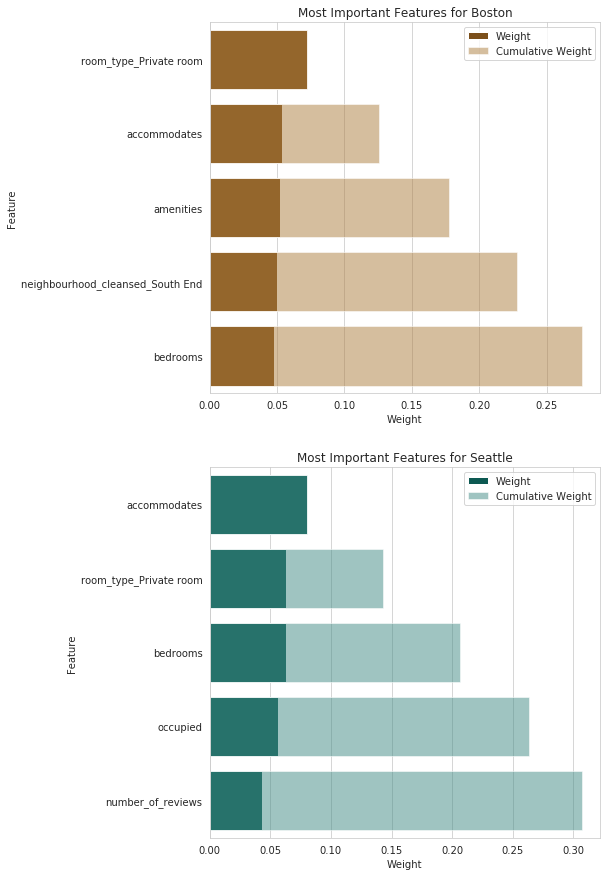

In [91]:
fig, axis = plt.subplots(len(cities), 1, figsize=(7,15))

for i, city in enumerate(cities):
    parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 
                  'n_estimators':[100, 150, 200, 250, 300, 350, 400, 500, 1000]}
    
    df = locals()[city+'_df_price'].copy()
    y = df['score']
    X = df.drop(['score'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    
    ab_clf = locals()[city+'_clf']
    grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
    grid_clf.fit(X_train, y_train)
    print('{}: accuracy:{}'.format(city, grid_clf.best_score_))

    best_clf = grid_clf.best_estimator_
    locals()[city+'_best_clf'] = best_clf
    
    print('{}: test accuracy score:{}'.format(city, 
                                              accuracy_score(y_test, best_clf.predict(X_test))))
          
    best_clf.fit(X, y)
    features = pd.DataFrame(best_clf.feature_importances_,
                                   index = X.columns, columns=['importance'])\
    .sort_values('importance', ascending=False)

    features.reset_index(inplace=True)
    features['cumsum'] = np.cumsum(features['importance'])
    
    colors = locals()[city+'_colors']
    sns.barplot(x='importance', y='index', data=features.iloc[:5], 
                ax=axis[i], color=colors[0], ci=None, label='Weight')
    sns.barplot(x='cumsum', y='index', data=features.iloc[:5], 
                ax=axis[i], color=colors[1], alpha=0.5, ci=None, label='Cumulative Weight')
    axis[i].legend()
    axis[i].set_ylabel('Feature')
    axis[i].set_xlabel('Weight')
    axis[i].set_title('Most Important Features for {}'.format(city.capitalize()))

Grid search improved the result a bit.

In question 2 we asked if we can determine what are the main predictors for property price. The answer is yes, given that we create different classes for the price value. 

We found that for Boston the most important features determining price are:

1. Room is a private room
2. Number of people that can be accommodated in the property
3. Number of amenities
4. If the property is in South End
5. Nummber of bedrooms

For Seattle the result is mostly the same. The important features determining price are:

1. How many people the room can accomodate
2. Room is a private room
3. Number of bedrooms
4. How many days unit is occupied during the year
5. Number of reviews

As we can see the trends are the same for both cities. The most valuable properties have private rooms, they can accomodate a family, have more than one bedroom and they are located in central areas. The result makes sense.

### Extra: 

Just because I found it interesting, I am adding here two attempts to improve the results by modifying the dataset (only for Boston). First, I tried to add all the elements of each column and select only the columns whose sum were larget than a cuttof. That's a way to select only the most important columns according to how restrictive the cutoff is.

In [92]:
cutoffs=[2500, 2000, 1500, 1000, 500, 100, 50, 30, 25, 0]

df = boston_df_price.copy()
y = df['score']
X = df.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    
for c in cutoffs:
    X_red = X_train.iloc[:, np.where((X.sum()>c)==True)[0]]
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_c = []
    y_preds_c = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        boston_best_clf.fit(X_train_kf, y_train_kf)
        y_preds_c.extend(boston_best_clf.predict(X_test_kf))
        y_true_c.extend(y_test_kf)
    print('cuttoff: {}, accuracy: {}'.format(c, accuracy_score(y_true_c, y_preds_c)))

cuttoff: 2500, accuracy: 0.36942940441482713
cuttoff: 2000, accuracy: 0.36942940441482713
cuttoff: 1500, accuracy: 0.40774677217825905
cuttoff: 1000, accuracy: 0.478134110787172
cuttoff: 500, accuracy: 0.5247813411078717
cuttoff: 100, accuracy: 0.5501874219075386
cuttoff: 50, accuracy: 0.556018325697626
cuttoff: 30, accuracy: 0.556018325697626
cuttoff: 25, accuracy: 0.5510204081632653
cuttoff: 0, accuracy: 0.5535193669304457


Using all columns (the smaller the cutoff the more columns are used) led to the best result. We don't drop any column.

Another interesting way of optimizing the dataframe is by using Recursive Feature Elimination. Despite the ugly name, this technique is not that complicated. We define the number of features we want and RFE will eliminate the least important columns until we get that number.

In [93]:
rfe_n = []
rfe_acc = []
for i in range(2,X.shape[1]):
    rfe_ab = RFE(boston_best_clf, n_features_to_select=i)
    rfe_ab = rfe_ab.fit(X, y)
    X_red = X_train.iloc[:,rfe_ab.support_]
    rfe_n.append(i)
    
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_rfe = []
    y_preds_rfe = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        boston_best_clf.fit(X_train_kf, y_train_kf)
        y_preds_rfe.extend(boston_best_clf.predict(X_test_kf))
        y_true_rfe.extend(y_test_kf)
    rfe_acc.append(accuracy_score(y_true_rfe, y_preds_rfe))

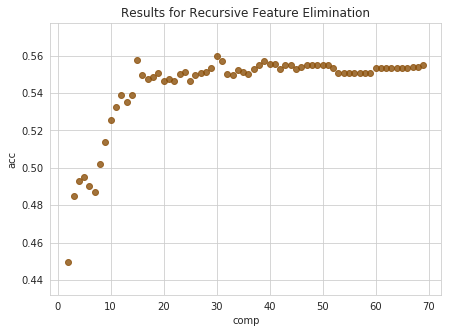

In [96]:
df_rfe = pd.DataFrame({'comp':rfe_n, 'acc':rfe_acc})
fig, ax1 = plt.subplots(1, figsize=(7,5))
sns.regplot(x='comp', y='acc', ax=ax1, data=df_rfe, color=boston_colors[0], fit_reg=False);
plt.title('Results for Recursive Feature Elimination');

## 4. What makes a property desirable?

Now, we would like to know what are the characteristics of properties that are in high demand (in terms of number or rentings). To solve this question we can use the same trick as above: define a four-star classification based in occupation which is the number of days a unit has been rented out.

The idea here is to use PCA to reduce dimensionality of the dataset and to aggregate original features into new variables, which are more meaningful for this problem. Then, using k-means clustering, we will find how these features are aggregated in different classes. Last but not the least, we will find to which classes most of the 4-star properties belong. That solves our question.

Fear not! This is not as complicated as it sounds.

In [263]:
for city in cities:

    df = locals()[city+'_df'].copy()
    target='occupied'
    qt = df[target].quantile([.25,.50,.75]).values.tolist()
    df_target = pd.Series(df[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )
    locals()[city+'_df'] = df.copy()
    locals()[city+'_target'] = df_target.copy()

In [264]:
boston_df.shape, seattle_df.shape, boston_target.shape, seattle_target.shape

((3585, 71), (3816, 135), (3585,), (3816,))

In [265]:
def pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim_{}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

Our PCA model has 20 dimensions, which corresponds to about 80% of explained variance. Keep in mind that the original dataframe had 71 dimensions

In [345]:
n_dim = 20
for city in cities:
    model, var_pca, X_pca = pca(locals()[city+'_df'], n_dim)
    locals()[city+'_model'] = model
    locals()[city+'_var_pca'] = var_pca
    locals()[city+'_X_pca'] = X_pca

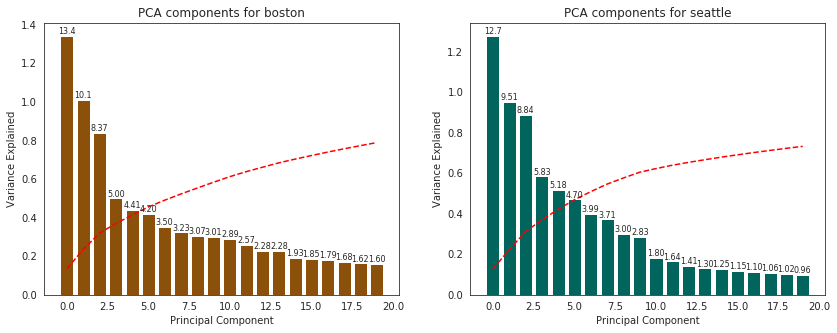

In [346]:
fig, axis = plt.subplots(1,len(cities),figsize=(14,5))
i = 0
for city in cities:
    scree_plot_pca(locals()[city+'_model'], axis[i], color=locals()[city+'_color'][0])
    axis[i].set_title('PCA components for {}'.format(city))
    i += 1

Next we must check which columns are the most important for each PCA component. 

In [347]:
boston_var_pca.head()

,Explained_Variance,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
Dim_0,0.1342,0.0210,-0.1030,-0.0530,0.0162,-0.1055,-0.0669,-0.0137,-0.0423,-0.0230,0.0362,-0.0154,-0.0023,-0.0006,0.0027,0.0561,0.0058,0.0043,0.0035,-0.0097,0.0070,0.0097,-0.0171,0.0144,-0.0401,0.0043,0.0146,-0.0662,-0.0022,-0.0428,0.0235,0.0035,-0.0201,0.0750,-0.0196,0.0136,-0.0087,0.0081,0.0766,0.0022,0.0018,0.0047,0.0178,-0.0222,0.0111,0.0122,0.0036,-0.0122,-0.0637,-0.0137,0.0068,0.0054,-0.0048,0.0004,-0.0093,0.0006,0.0018,-0.0005,0.1261,-0.0007,-0.0030,0.0070,0.0021,0.4356,-0.0049,0.0010,0.0122,0.0038,-0.0311,0.4822,-0.7042,-0.0066
Dim_1,0.1012,0.0214,0.3147,0.3940,0.1430,-0.1017,-0.0502,0.0074,-0.0321,-0.0150,0.0046,-0.0231,-0.0008,0.0003,-0.0075,-0.1363,0.0457,-0.0007,0.0047,-0.0022,0.0082,0.0118,-0.0359,0.0037,0.2187,0.0143,-0.0761,-0.0961,-0.0004,-0.0176,0.0292,0.0003,-0.0160,0.1087,-0.0523,0.0266,-0.1002,0.0137,0.0641,-0.0013,-0.0014,0.0161,-0.0021,-0.0218,0.0243,0.0350,0.0147,-0.0215,-0.0520,-0.0138,0.0177,0.0184,0.0004,-0.0009,-0.0113,0.0007,-0.0003,0.0000,0.3435,-0.0099,0.0030,0.0163,-0.0021,0.5942,-0.0216,-0.0001,0.0097,-0.0029,-0.0175,-0.1478,0.2988,-0.0582
Dim_2,0.0838,0.0621,-0.5037,-0.4765,-0.1523,-0.0346,-0.0647,-0.0025,-0.0421,-0.0269,0.0902,-0.0111,0.0016,-0.0004,0.0101,0.1271,-0.0441,-0.0271,-0.0191,-0.0446,-0.0105,-0.0157,-0.0198,-0.0221,-0.0959,-0.0268,-0.0990,-0.0354,-0.0057,-0.0144,0.0373,0.0024,-0.0104,0.0085,-0.0180,-0.0094,0.0018,0.0069,-0.0225,-0.0019,-0.0005,0.0049,0.0224,-0.0145,-0.0010,0.0062,-0.0070,-0.0105,-0.0192,-0.0037,0.0077,0.0069,-0.0013,0.0001,-0.0240,0.0006,-0.0016,-0.0002,0.0864,-0.0021,0.0058,-0.0002,0.0043,0.4239,-0.0085,-0.0010,0.0081,-0.0025,-0.0006,-0.4802,0.0980,-0.0168
Dim_3,0.0500,0.1620,-0.1783,0.0294,-0.1055,-0.1016,0.0118,-0.0135,0.0036,0.0068,-0.0295,-0.0018,-0.0048,0.0015,0.0161,0.1672,0.0069,-0.0033,0.0000,-0.0054,0.0007,0.0050,-0.0068,0.0078,0.8761,-0.0541,-0.1908,-0.0588,0.0050,0.0214,0.0584,0.0126,-0.0166,-0.0593,0.0097,0.0372,-0.0314,-0.0092,-0.0907,-0.0002,0.0017,0.0026,-0.0111,0.0501,-0.0124,0.0106,0.0350,-0.0131,0.0177,-0.0176,-0.0006,-0.0055,0.0027,0.0020,0.1077,0.0016,-0.0008,-0.0001,-0.1141,0.0071,-0.0045,-0.0088,0.0021,-0.1103,0.0156,0.0031,-0.0081,-0.0011,0.0105,-0.0125,-0.1117,-0.0776
Dim_4,0.0442,-0.0166

In [348]:
def pca_analysis(var_pca, component):
    '''
    Generate a dataframe with the attributes listed by weight for
    a given component.
    
    INPUT: var_pca - dataframe with the PCA output
           component - number of the component
           
    OUTPUT: dataframe with attributes and weights
    '''
    
    df = pd.DataFrame(var_pca.iloc[component,:].sort_values(axis=0, ascending=False))
    df['attribute_{}'.format(component)] = df.index
    df.set_index(np.arange(var_pca.shape[1]), inplace=True)

    return df

In [349]:
for city in cities:
    list_ = []
    var_pca = locals()[city+'_var_pca'].copy()
    var_pca.drop('Explained_Variance', axis=1, inplace=True)
    for i in range(0, n_dim):
        list_.append(pca_analysis(var_pca, i))
    locals()[city+'_var_comp'] = pd.concat([x for x in list_], axis = 1).reset_index()

In [350]:
boston_var_comp.head()

,index,Dim_0,attribute_0,Dim_1,attribute_1,Dim_2,attribute_2,Dim_3,attribute_3,Dim_4,attribute_4,Dim_5,attribute_5,Dim_6,attribute_6,Dim_7,attribute_7,Dim_8,attribute_8,Dim_9,attribute_9,Dim_10,attribute_10,Dim_11,attribute_11,Dim_12,attribute_12,Dim_13,attribute_13,Dim_14,attribute_14,Dim_15,attribute_15,Dim_16,attribute_16,Dim_17,attribute_17,Dim_18,attribute_18,Dim_19,attribute_19
0,0,0.4822,cancellation_policy_moderate,0.5942,room_type_Private room,0.4239,room_type_Private room,0.8761,instant_bookable,0.5708,property_type_House,0.5189,property_type_House,0.4983,host_is_superhost,0.6585,neighbourhood_cleansed_South End,0.5122,neighbourhood_cleansed_Fenway,0.5614,neighbourhood_cleansed_Back Bay,0.5330,host_is_superhost,0.6323,neighbourhood_cleansed_Dorchester,0.3332,neighbourhood_cleansed_Beacon Hill,0.7990,property_type_Condominium,0.7301,neighbourhood_cleansed_Beacon Hill,0.2746,neighbourhood_cleansed_South Boston,0.7552,neighbourhood_cleansed_Brighton,0.3470,occupied,0.3254,neighbourhood_cleansed_East Boston,0.4598,neighbourhood_cleansed_Downtown
1,1,0.4356,room_type_Private room,0.3940,host_acceptance_rate,0.1271,occupied,0.1672,occupied,0.4115,host_is_superhost,0.3241,require_guest_phone_verification,0.3876,require_guest_phone_verification,0.2252,cancellation_policy_moderate,0.3688,cancellation_policy_moderate,0.3952,cancellation_policy_moderate,0.3164,neighbourhood_cleansed_Fenway,0.1641,neighbourhood_cleansed_Beacon Hill,0.2295,neighbourhood_cleansed_Downtown,0.3757,neighbourhood_cleansed_South Boston,0.1668,occupied,0.2447,neighbourhood_cleansed_Fenway,0.2046,property_type_Condominium,0.2486,bed_type_Futon,0.2875,neighbourhood_cleansed_North End,0.3684,property_type_Condominium
2,2,0.1261,property_type_House,0.3435,property_type_House,0.0980,cancellation_policy_strict,0.1620,host_since,0.3652,neighbourhood_cleansed_Jamaica Plain,0.2547,host_listings_count,0.2379,neighbourhood_cleansed_Jamaica Plain,0.2216,require_guest_phone_verification,0.3571,cancellation_policy_strict,0.3467,cancellation_policy_strict,0.1513,neighbourhood_cleansed_Dorchester,0.1377,neighbourhood_cleansed_Downtown,0.2155,neighbourhood_cleansed_Brighton,0.1184,bedrooms,0.1605,neighbourhood_cleansed_Fenway,0.1402,room_type_Shared room,0.1918,require_guest_phone_verification,0.2337,room_type_Shared room,0.2819,neighbourhood_cleansed_Roxbury,0.2148,neighbourhood_cleansed_East Boston
3,3,0.0766,neighbourhood_cleansed_Jamaica Plain,0.3147,host_response_rate,0.0902,amenities,0.1077,property_type_Condominium,0.1320,bedrooms,0.2161,instant_bookable,0.2300,cancellation_policy_super_strict_30,0.1755,neighbourhood_cleansed_Dorchester,0.2574,neighbourhood_cleansed_Jamaica Plain,0.1277,room_type_Private room,0.1392,host_since,0.0906,bedrooms,0.1716,neighbourhood_cleansed_South Boston,0.1129,bed_type_Real Bed,0.1471,require_guest_phone_verification,0.1341,neighbourhood_cleansed_Roxbury,0.1452,occupied,0.2073,require_guest_phone_verification,0.2488,occupied,0.1412,neighbourhood_cleansed_Fenway
4,4,0.0750,neighbourhood_cleansed_Dorchester,0.2988,cancellation_policy_strict,0.0864,property_type_House,0.0584,neighbourhood_cleansed_Brighton,0.1013,accommodates,0.1952,cancellation_policy_super_strict_30,0.2241,instant_bookable,0.1446,cancellation_policy_strict,0.2497,host_listings_count,0.1107,neighbourhood_cleansed_Jamaica Plain,0.1341,neighbourhood_cleansed_Back Bay,0.0876,neighbourhood_cleansed_North End,0.1427,require_guest_phone_verification,0.1086,require_guest_phone_verification,0.1278,property_type_Condominium,0.1238,property_type_Condominium,0.1291,room_type_Shared room,0.1867,neighbourhood_cleansed_Roxbury,0.2270,bed_type_Real Bed,0.1026,property_type_House


In [351]:
seattle_var_comp.head()

,index,Dim_0,attribute_0,Dim_1,attribute_1,Dim_2,attribute_2,Dim_3,attribute_3,Dim_4,attribute_4,Dim_5,attribute_5,Dim_6,attribute_6,Dim_7,attribute_7,Dim_8,attribute_8,Dim_9,attribute_9,Dim_10,attribute_10,Dim_11,attribute_11,Dim_12,attribute_12,Dim_13,attribute_13,Dim_14,attribute_14,Dim_15,attribute_15,Dim_16,attribute_16,Dim_17,attribute_17,Dim_18,attribute_18,Dim_19,attribute_19
0,0,0.6478,cancellation_policy_strict,0.7436,property_type_House,0.0987,cancellation_policy_strict,0.5004,property_type_House,0.5188,host_is_superhost,0.3998,require_guest_phone_verification,0.9046,instant_bookable,0.9123,occupied,0.9411,neighbourhood_cleansed_Broadway,0.1885,require_guest_phone_verification,0.3844,bed_type_Futon,0.8843,neighbourhood_cleansed_Belltown,0.8014,neighbourhood_cleansed_Wallingford,0.8417,neighbourhood_cleansed_Fremont,0.5084,host_response_rate,0.3940,host_response_rate,0.8085,neighbourhood_cleansed_Minor,0.5330,neighbourhood_cleansed_Stevens,0.5650,property_type_Townhouse,0.6651,host_since
1,1,0.1524,require_guest_phone_verification,0.4309,room_type_Private room,0.0842,room_type_Private room,0.2686,cancellation_policy_moderate,0.4845,require_guest_phone_verification,0.3604,require_guest_profile_picture,0.1311,require_guest_phone_verification,0.1355,host_acceptance_rate,0.1078,property_type_House,0.1848,require_guest_profile_picture,0.3273,room_type_Shared room,0.1171,neighbourhood_cleansed_Broadway,0.2520,bed_type_Real Bed,0.2477,host_acceptance_rate,0.3926,neighbourhood_cleansed_Wallingford,0.2962,neighbourhood_cleansed_University District,0.1984,amenities,0.3914,host_since,0.5489,neighbourhood_cleansed_Stevens,0.5152,neighbourhood_cleansed_University District
2,2,0.1516,host_acceptance_rate,0.2737,cancellation_policy_strict,0.0826,property_type_House,0.1709,occupied,0.4466,require_guest_profile_picture,0.2108,cancellation_policy_moderate,0.1187,require_guest_profile_picture,0.1320,room_type_Private room,0.1021,cancellation_policy_strict,0.1292,property_type_House,0.1969,bed_type_Pull-out Sofa,0.1058,property_type_House,0.1549,amenities,0.0987,amenities,0.2948,neighbourhood_cleansed_Fremont,0.2895,neighbourhood_cleansed_Stevens,0.1956,host_response_rate,0.2306,room_type_Shared room,0.1629,bedrooms,0.2365,property_type_Townhouse
3,3,0.1433,require_guest_profile_picture,0.1503,host_acceptance_rate,0.0550,amenities,0.1669,accommodates,0.1785,cancellation_policy_moderate,0.1255,host_acceptance_rate,0.0835,room_type_Private room,0.1122,host_response_rate,0.0874,amenities,0.1134,instant_bookable,0.1557,cancellation_policy_strict,0.0844,bed_type_Futon,0.1396,room_type_Shared room,0.0910,neighbourhood_cleansed_Belltown,0.1043,bedrooms,0.2048,amenities,0.1624,neighbourhood_cleansed_Fremont,0.1326,neighbourhood_cleansed_First Hill,0.1405,room_type_Shared room,0.2262,room_type_Shared room
4,4,0.1204,host_response_rate,0.1387,host_response_rate,0.0544,occupied,0.1479,bedrooms,0.1240,occupied,0.0947,neighbourhood_cleansed_Belltown,0.0770,cancellation_policy_strict,0.1098,require_guest_profile_picture,0.0667,cancellation_policy_moderate,0.1058,room_type_Shared room,0.1424,neighbourhood_cleansed_Wallingford,0.0615,property_type_Condominium,0.0646,neighbourhood_cleansed_University District,0.0894,neighbourhood_cleansed_Wallingford,0.1038,review_scores_cleanliness,0.1627,room_type_Shared room,0.1483,room_type_Shared room,0.1323,neighbourhood_cleansed_Central Business District,0.1289,accommodates,0.1299,neighbourhood_cleansed_Wallingford


Now that we have the PCA axes in place, we can run k-means to generate clusters in this new space. Let's choose the number of dimensions.

In [154]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

In [199]:
def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: dataframe with kmeans step and scalar mean distance
    '''
    
    k_dist = []
    k_step = []
    for k in range(2,20):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        k_dist.append(dist_centroid(X_pca, k_model))
        k_step.append(k)
    #return dict(zip(k_step, k_dist))
    #return {key: value for (key, value) in zip(k_step, k_dist)}
    return pd.DataFrame({'step': k_step, 'dist': k_dist})

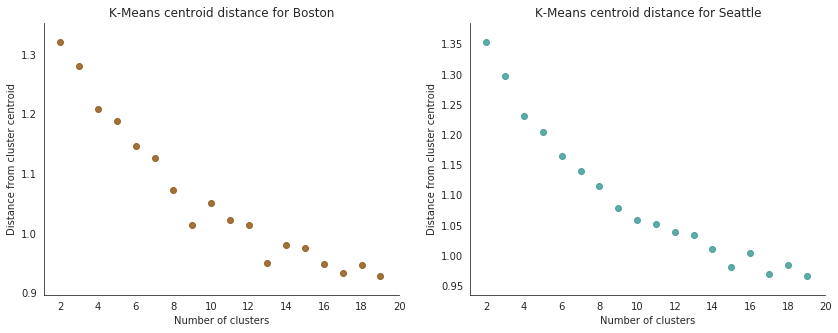

In [288]:
fig, axis = plt.subplots(1, len(cities), figsize=(14,5))
sns.despine()

for i,city in enumerate(cities):
    df_ = scree_plot_kmeans(locals()[city+'_X_pca'])
    color = locals()[city+'_color'][i]
    sns.regplot(x='step', y='dist', ax=axis[i], data=df_, color=color, fit_reg=False);
    axis[i].set_xticks(np.arange(min(df_.step), max(df_.step)+2, 2))
    axis[i].set_xlabel('Number of clusters')
    axis[i].set_ylabel('Distance from cluster centroid')
    axis[i].set_title('K-Means centroid distance for {}'.format(city.capitalize()))

Both curves show a small inflexion around 10 clusters. We will take this as the number.

Now, for the great moment, we will check which clusters have the highest population of properties with the maximum score (4) in terms of how long it is occupied.

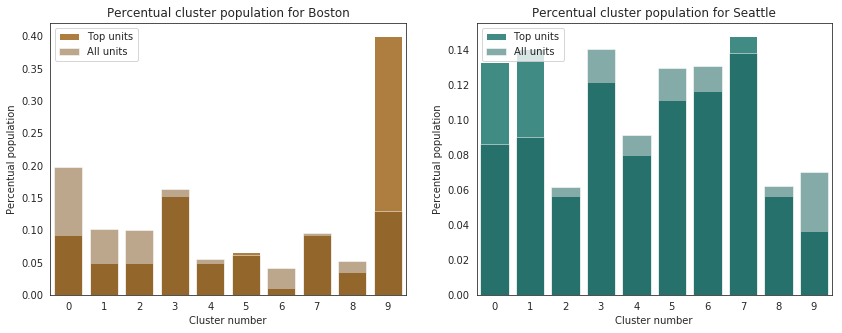

In [352]:
n_cluster = 10
fig, axes = plt.subplots(1, len(cities), figsize=(14,5))

for i,city in enumerate(cities):
        X_pca = locals()[city+'_X_pca']
        df_ = locals()[city+'_df']
        target_ = locals()[city+'_target']
    
        # generate kmeans model
        k_model = KMeans(n_clusters = n_cluster, random_state=34).fit(X_pca)
        
        cluster_score = pd.DataFrame()
        cluster_score['score'] = target_
        cluster_score['cluster'] = k_model.labels_
        
        cluster_grouped = pd.DataFrame({'cluster': cluster_score.cluster.unique(),
                                        'pop_all': cluster_score.cluster.value_counts(normalize=True),
                                        'pop_top': cluster_score[cluster_score['score']==4].cluster.
                                        value_counts(normalize=True)})
        
        
        color = locals()[city+'_color'][1]
        sns.barplot(x='cluster', 
                    y='pop_top', 
                    data=cluster_grouped, 
                    color=color, 
                    ax=axes[i], 
                    alpha=1.0, 
                    label='Top units')
        color = locals()[city+'_color'][0]
        sns.barplot(x='cluster', 
                    y='pop_all', 
                    data=cluster_grouped, 
                    color=color, 
                    ax=axes[i], 
                    alpha=0.5, 
                    label='All units')
        
        axes[i].set_title('Percentual cluster population for {}'.format(city.capitalize()))
        axes[i].legend(loc='upper left')
        axes[i].set_xlabel('Cluster number')
        axes[i].set_ylabel('Percentual population')
        #print('city: {} {}'.format(city.capitalize(), cluster_top_score[cluster_top_score['score']==4]['cluster'].
        #                           value_counts().to_dict()))

        locals()[city+'_kmodel'] = k_model

Wow. It worked very well for Boston and not so well for Seattle. In Boston cluster 9 is clearly overpopulated by top units while in Seattle clusters 0 and 1 have an excess of top units. Let's check what are the attributes of these units.

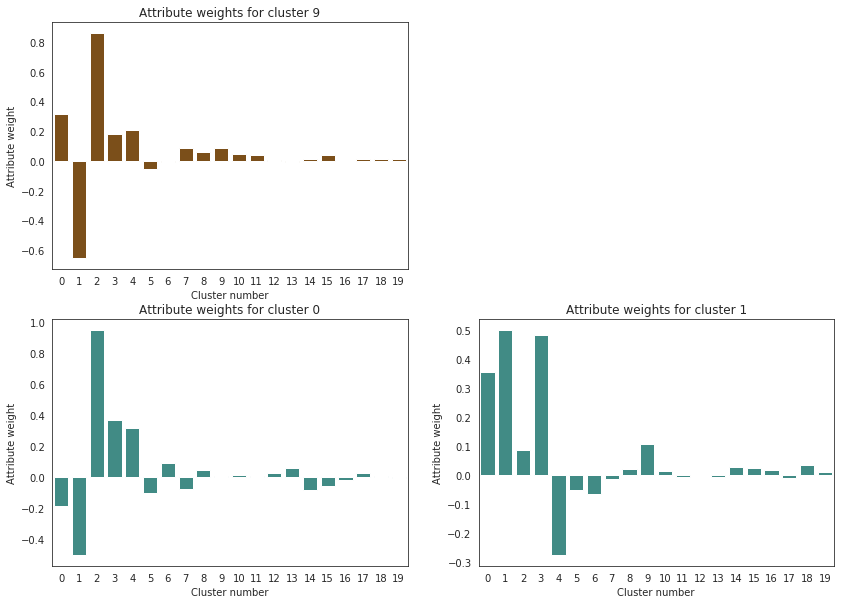

In [366]:
boston_clusters = [9]
seattle_clusters = [0,1]

fig, axis = plt.subplots(2, len(cities), figsize=(14,10))

for i, city in enumerate(cities):
    clusters = locals()[city+'_clusters']
    for j, cluster in enumerate(clusters):
        kmodel = locals()[city+'_kmodel']
        color = locals()[city+'_color'][i]
        sns.barplot(x = np.arange(0, kmodel.cluster_centers_[cluster].shape[0]), 
                    y = kmodel.cluster_centers_[cluster], 
                    ax=axis[i][j], color=color)
        axis[i][j].set_xlabel('Cluster number')
        axis[i][j].set_ylabel('Attribute weight')
        axis[i][j].set_title('Attribute weights for cluster {}'.format(cluster))
        
fig.delaxes(axis[0][1])

#### For Boston
* For cluster 9 the most important attributes are 0, 2 (positive) and 1 (negative)
    * attribute 0 describes units in Jamaica Plain or Dorchester with moderate cancellation policy. Property is a house with private rooms 
    * attribute 2 describes units that are occupied for most of the time. Property is also a house with private rooms and several amenities. Cancellation policy is strict.
    * attribute 1 describes units in Black Bay or Fenway. They are heavily occupied and the host has several properties. Cancellation policy is moderate.
    
#### For Seattle
* For cluster 0 the most important attributes are 1 (negative) and 2 (positive)
    * attribute 1: properties in Belltown and Broadway with moderate cancellation policy and long-time hosts
    * attribute 2: Houses with private rooms, many amenities and cancellation policy strict.
    
* For cluster 2 the most important attributes are 0, 1, 3 (positive) and 4 (negative)
    * attribtue 0: units with cancellation policy strict, that require guest phone and profile verification. Host acceptance rate and response rate are high. (this feature is a bit too broad)
    * attribute 1: Houses that have private rooms
    * attribute 3: Houses that are constantly occupied. They have several bedrooms and can accomodate many people. They have cancellation policy moderate.
    * attribute 4: Houses that are instantly_bookable with long-time hosts. They have high response rate and high acceptance rate
    
Yes, we made it. These are the characteristics of the properties that have been mostly occupied in both cities. They share several common features like being a house, with many bedrooms and private rooms. Properties in central locations are also popular.

In [98]:
#boston_var_comp[['attribute_0','attribute_2']].head()

In [368]:
#boston_var_comp[['attribute_1']].tail()

In [369]:
seattle_var_comp[['attribute_0','attribute_1','attribute_2','attribute_3']].head()

,attribute_0,attribute_1,attribute_2,attribute_3
0,cancellation_policy_strict,property_type_House,cancellation_policy_strict,property_type_House
1,require_guest_phone_verification,room_type_Private room,room_type_Private room,cancellation_policy_moderate
2,host_acceptance_rate,cancellation_policy_strict,property_type_House,occupied
3,require_guest_profile_picture,host_acceptance_rate,amenities,accommodates
4,host_response_rate,host_response_rate,occupied,bedrooms


In [370]:
seattle_var_comp[['attribute_1', 'attribute_4']].tail()

,attribute_1,attribute_4
130,host_since,property_type_House
131,neighbourhood_cleansed_Belltown,instant_bookable
132,occupied,host_since
133,neighbourhood_cleansed_Broadway,host_response_rate
134,cancellation_policy_moderate,host_acceptance_rate


## 5. What are the most popular neighbourhoods? 

### Can we understand why they are popular?

To solve this question we can use the neighborhood overview from the listings dataframe. The intereting thing about overviews is that they tend to be more well-behaved than the wild west of the reviews. The host will take more time to tailor the language which turns the text easier to be processed. Moreover, from what I have checked, all overviews are in English.

The idea here is to aggregate reviews per neighborhood, turn them into a bag of words and process them usign Latent Dirichlet Allocation, a Bayesian tool for analysis of trends in texts.

Because the results of this analysis are quite lenghty I will do it only for Boston.

The first we notice in the listings dataframe is that almost 40% of the overviews are missing (come on, how can someone post a property and not write an overview?). 

In [1427]:
# 40% of neighborhood overviews missing
boston_listings['neighborhood_overview'].isnull().mean()

0.3947001394700139

We select only the list that are not null and create a new dataframe

In [1450]:
bl_no = boston_listings.loc[boston_listings['neighborhood_overview'].notnull(), 
                            ['neighbourhood_cleansed','neighborhood_overview']].copy()
bl_no.head()

,neighbourhood_cleansed,neighborhood_overview
0,Roslindale,"Roslindale is quiet, convenient and friendly. For Southern food try Redd's in Rozzie. Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pricier. If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods; for a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch St."
1,Roslindale,"The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away."
2,Roslindale,"The LOCATION: Roslindale is a safe and diverse Boston neighborhood located between Jamaica Plain and West Roxbury. This apartment is on Ardale Street, a quiet side street off Centre Street. This is about one-half mile from Faulkner Hospital, walking distance to the renowned Arnold Arboretum park (look for it on (SENSITIVE CONTENTS HIDDEN)), and about 20-minute drive to the Longwood Medical Center area. I have easy, restriction-free, on-street parking here, and a back yard. Just one block fr..."
3,Roslindale,"Roslindale is a lovely little neighborhood located right in the city of Boston. Though a part of the actual city, once you enter it, you feel as though you have escaped to a suburb with friendly neighbors. The area is conveniently located with access to the city’s bus and subway system. The Orange Line and Commuter Rail services connect the area to the heart of Boston and the neighboring towns. It is situated close to shops, restaurants, grocery stores, parks and neighboring towns. The ..."
4,Roslindale,"I love the proximity to downtown, the neighborhood pride, safety, nice shops and restaurants within a 8-minute walk. Roslindale is welcoming to all types of people. The City website describes it: ""Once considered a ""garden suburb"" of Boston, today's residents of Roslindale are still attracted to the neighborhood's natural beauty. Locals walk and bike in the Arnold Arboretum, a 265-acre oasis that is part of Frederick Law Olmsted's Emerald Necklace.....Roslindale Village is the city's orig..."


In [1430]:
bl_no.shape

(2170, 2)

Then we group the entries by neighborhood.

In [1466]:
bl_no_grouped = bl_no.groupby('neighbourhood_cleansed').agg({'neighborhood_overview':'sum'}).reset_index()
bl_no_grouped.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)
bl_no_grouped.head()

,neighbourhood,neighborhood_overview
0,Allston,"- The building is located on the border of Allston and Boston just west of Boston University. The building has a private parking lot (with parking tag of course - enquire with me if you drive) The building is surrounded by hedges and fences which gives it an intimate feel. - Super convenient and walkable - Shaws supermarket is a huge modern market with fresh produce, foreign or international foods, and every basic necessity you'll need. The market is just a few buildings away from our house..."
1,Back Bay,"Back BayGreat location near the Boston Common, Newbury Street, Esplanade, Charles River, Mass General Hospital and public transportation.Back Bay is an officially recognized neighborhood of Boston, Massachusetts famous for its rows of Victorian brownstone homes — considered one of the best-preserved examples of 19th-century urban design in the United States — as well as numerous architecturally significant individual buildings and important cultural institutions such as the Boston Public Lib..."
2,Bay Village,"- 1 block away from Loews Regency Hotel - 5 min walk to the Arlington Station - 5 min walk to Tufts Medical and Dental Center - Corner of Melrose and Arlington - Close to Theater District - Close to Quincy MarketOur townhome is located in the Bay Village neighborhood of Boston. It is nestled between Back Bay, the South End, and the Theatre District which make it the perfect spot for any traveler. Bay Village, known for its fabulous location and local charm, is steps from public transportatio..."
3,Beacon Hill,"Beacon Hill is a historic neighborhood of Boston famous for its gaslit lamps, brick sidewalks, and opulent mansions dating back to 1800. Our apartment is located on Mount Vernon Street, one of the first streets laid in the Beacon Hill area with many of the original homes preserved by the Beacon Hill Preservation Society. For history buffs: steps to the Black Heritage Trail, which follows the history of the Abolitionist movement and the Underground Railroad, the Freedom Trail, Louisberg Squa..."
4,Brighton,"Just steps away from the Charles River and easy driving access to Boston makes this neighborhood very convenient. The historic architecture is unique to the area. Sidewalk lined streets are fun to explore. Panoramic views of the City of Boston can be seen from neighboring streetsVery safe and convenient neighborhood close to Harvard Square. Walk to the grocery store, Brugger's bagels, sushi restaurant, wine store, breakfast places, restaurants, bus service to Harvard Square, etc.Cleveland ..."


In [1475]:
bl_no_grouped.shape

(25, 2)

We add boston to the list of stop words - the words that will not be considered as part of the vocabulary.

In [1493]:
my_stop_words=['boston','mi','miles']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [1504]:
list_msg=[]
for i in range(bl_no_grouped.shape[0]):
    count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
    X_train = count_vect.fit_transform([bl_no_grouped.loc[i,'neighborhood_overview']])
    lda = LatentDirichletAllocation(n_components=1,random_state=34)
    lda.fit(X_train) 
    feature_names = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        message = " ".join([feature_names[i] for i in topic.argsort()[:-8 :-1]])
    list_msg.extend([message])

In [1505]:
bl_no_grouped['message']=list_msg

Let's also add to this dataframe the mean classification score for number of rents

In [1550]:
boston_df.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,0.000,0.9,0.78,0.0,0.008011,0.000000,0.166667,0.2,0.0625,0.666667,0.007519,0.020067,3.640000e-06,0.000564,0.203509,0.084158,0.8750,0.875,0.750,0.875,0.833333,0.875,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0.125,1.0,0.90,0.0,0.009346,0.066667,0.166667,0.2,0.0625,0.766667,0.033835,0.006689,7.290000e-06,0.006769,0.036842,0.089109,0.8875,0.875,1.000,1.000,1.000000,0.875,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,0.125,1.0,0.90,0.0,0.009346,0.200000,0.166667,0.2,0.1250,0.433333,0.046366,0.006689,7.290000e-06,0.004680,0.071930,0.116337,0.9375,0.875,1.000,1.000,1.000000,0.750,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.125,1.0,0.88,1.0,0.001335,0.066667,0.166667,0.2,0.0625,0.433333,0.013784,0.006689,4.400000e-07,0.000224,0.080702,0.101485,0.9750,1.000,0.875,1.000,1.000000,0.875,1.000,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,0.125,1.0,0.93,0.0,0.016021,0.133333,0.166667,0.2,0.0625,0.733333,0.036090,0.096990,3.640000e-06,0.019427,0.205263,0.044554,0.8875,1.000,0.875,1.000,0.833333,1.000,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [1592]:
bdf_lda = boston_df.copy()
bdf_lda['rent_score'] = boston_target
bdf_lda['neighbourhood'] = boston_neigh
bdf_lda_grouped = bdf_lda.groupby('neighbourhood').agg({'rent_score':'mean','review_scores_rating':'mean'})
bdf_lda_grouped.rename(columns={'review_scores_rating':'review_score'},inplace=True)

In [1593]:
bl_no_lda = bl_no_grouped.merge(bdf_lda_grouped, on='neighbourhood')

In [1615]:
bl_no_lda[['neighbourhood','message','rent_score', 'review_score']].sort_values(by='rent_score', ascending=False)

,neighbourhood,message,rent_score,review_score
16,Mission Hill,fine arts longwood medical museum fine minute walk mission hill medical area northeastern university,2.919355,0.864063
0,Allston,harvard square min walk charles river students young walk away young professionals restaurants bars,2.819231,0.883630
21,South Boston Waterfront,walking distance seaport district section city district hottest fort point harpoon brewery lots businesses,2.734940,0.920921
22,South End,south end copley square walking distance newbury street end bay minute walk neighborhoods south,2.708589,0.912813
3,Beacon Hill,beacon hill charles street charles river state house hill historic antique shops brick sidewalks,2.675258,0.914879
17,North End,north end paul revere italian restaurants little italy faneuil hall public transportation old north,2.629371,0.917927
10,Fenway,fenway park longwood medical heart dynamic parks theaters theaters nightlife museum fine museums parks,2.620690,0.878811
4,Brighton,harvard square walking distance close harvard grocery store green line wine store store breakfast,2.610811,0.889505
12,Jamaica Plain,jamaica plain jamaica pond arnold arboretum minute walk walking distance green space franklin park,2.586006,0.923069
8,Downtown,faneuil hall downtown crossing north end public garden opera house td garden beacon hill,2.534884,0.903379


In [1616]:
bl_no_lda.sort_values(by='rent_score', ascending=False, inplace=True)

The following are the most popular neighborhoods of Boston in terms of renting:

1. Mission Hill: It's at walking distance from the fine arts museum, it has the Longwood medical center and it is close to Harvard university
2. Allston - close to Harvard, within minutes walk from Charles river. Many young professionals leave there and it has several restaurants and bars
3. South Boston Waterfront - it is at walking distance from the seaport district. It is one of the hottest districts in the city and it is the location of the Harpoon brewery. There are lots of businesses.
4. South End - Copley square is at walking distance. It is crossed by Newbury street which has many restaurants and retails. 
5. Beacon Hill - Close to Charles street and Charles river. It is an historic neighborhood with brick sidewalls and antique shops.

That was interesting. It looks like we managed to get some meaningful information out of this mess.

## Conclusions

Using data manipulation and machine learning we managed to generate quite interesting insights from a particularly challenging dataset. Here is what we learned from the dataset:

* demand is high during spring and summer. For all months Boston is in higher demand than Seattle
* 25% of the properties in Boston are rented all year round. These properties are probably mostly rented to students
* price was predicted with around 60% accuracy. The most important features for price determination that are common to both cities are:
    * rooms are private
    * number of people that can be accommodated
    * number of bedrooms
* the most sought-after properties can be grouped by common fetures. Some of the most common features were:
    * rooms are private
    * number of bedrooms
    * cancellation policy is moderate
    * hosts have high reputation
* for Boston, the hottest neighbourhoods were Mission Hill, Allston, South Boston waterfron, South End, Beacon Hill. These places were in general close to universities, historic neighbourhoods or street shopping.

We covered a lot of ground but we could have done much more with this dataset. One question that I would like to tackle is if the reviews are consistent with the ratings for each property. It also would be interesting to extend this analysis to a longer timeframe so we could get better accuracy for the price predictions. Maybe some other time.